# Setup

In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils import data

from torch.autograd import Variable, Function

from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

from PIL import Image
import numpy as np
import pandas as pd
from skimage.morphology import label
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

# Constants

In [10]:
BATCH_SIZE = 64
IMG_PATH = '/home/yvan/projects/data_sci_bowl_2018/data'
N_EPOCHS = 31
FILTER_DEPTH = 1
LR = 0.001

# Data Processing

In [11]:
#create a custom imageloader that gets the name of the file as well
class YvanImageFolder(ImageFolder):
    def __getitem__(self,index):
        return super(YvanImageFolder, self).__getitem__(index), self.imgs[index]

In [12]:
# data process
img_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
])

img_dataset = YvanImageFolder(os.path.join(IMG_PATH, 'train_img'), img_transform)
img_loader = data.DataLoader(dataset=img_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

In [13]:
# mask process
mask_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

mask_dataset = YvanImageFolder(os.path.join(IMG_PATH,'train_mask'),mask_transform)
mask_loader = data.DataLoader(dataset=mask_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=1)

In [14]:
for (img, img_name), (mask, mask_name) in zip(img_loader, mask_loader):
    a,b = img[0], mask[0]
    test_img = transforms.ToPILImage()(a[0])
    test_mask = transforms.ToPILImage()(b[0])
    print(a.size(), b.size())
    print(torch.max(a[0]), torch.min(a[0]), torch.max(b[0]), torch.min(b[0]))
    break

torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])
0.40392157435417175 0.003921568859368563 1.0 0.0


Ok so we can convert our stuff into tensors and convert them back into images.

# Unet model

referenced: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

In [28]:
from utils import *
    
### conv building block ###

class conv_block(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_chan),
            nn.Conv2d(in_chan, out_chan, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, 3, padding=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

### inputs and outputs ###

class in_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(in_conv, self).__init__()
        self.conv = conv_block(in_chan, out_chan)
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
class out_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(out_conv, self).__init__()
        self.conv = nn.Conv2d(in_chan, out_chan, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        return self.activation(self.conv(x))
    
### actual con blocks ###

class conv_down(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_down, self).__init__()
        self.pool_conv = nn.Sequential(
            conv_block(in_chan, out_chan),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.pool_conv(x)
        return x

class conv_up(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_up, self).__init__()
        self.conv_up = nn.ConvTranspose2d(in_chan, out_chan, 2, stride=2)
        self.conv = conv_block(2*out_chan, out_chan)
    
    def forward(self, x1, x2):
        x1 = self.conv_up(x1)
        x = torch.cat([x2,x1],dim=1)
        x = self.conv(x)
        return x

class unet1(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(unet1, self).__init__()
        self.inc = in_conv(in_chan, 16)
        self.down1 = conv_down(16, 32)
        self.down2 = conv_down(32, 64)
        self.down3 = conv_down(64, 128)
        self.down4 = conv_down(128, 256)
        self.up1 = conv_up(256, 128)
        self.up2 = conv_up(128, 64)
        self.up3 = conv_up(64, 32)
        self.up4 = conv_up(32, 16)
        self.out = out_conv(16, out_chan)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
        return x
    
def weights_init(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.xavier_uniform(m.weight, gain=np.sqrt(2))
        nn.init.constant(m.bias,0.0)
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.normal_(1.0,0.02)
        m.bias.data.fill_(0)

creating model with 1942259 params and intial param sum 728.0030780434608
training epoch 0
training epoch 10
training epoch 20
training epoch 30


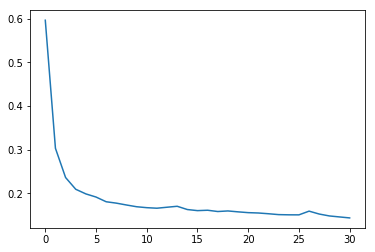

In [29]:
# create a unet
unet = unet1(FILTER_DEPTH, FILTER_DEPTH)
unet.apply(weights_init)
opti = optim.Adam(unet.parameters(), lr=LR, betas=(0.5,0.99))
loss = DiceLoss()

nparams = sum([param.nelement() for param in unet.parameters()])
psum = check_param_sum(unet)
print(f'creating model with {nparams} params and intial param sum {psum}')

if torch.cuda.is_available():
    unet.cuda()
    loss.cuda()

losses = []

for epoch in range(N_EPOCHS):
    epoch_loss = []
    if not epoch % 10: print(f'training epoch {epoch}')
    for (batch, batch_name), (mask_batch, mask_name) in zip(img_loader, mask_loader):
        image_batch = to_variable(batch[0])
        labels = to_variable(mask_batch[0])

        x = unet(image_batch)
        l = loss(x, labels)
        epoch_loss.append(l.data[0])
        l.backward()
        opti.step()
        unet.zero_grad()
    losses.append(np.mean(epoch_loss))
    epoch_loss = []
    
plt.plot(losses)
plt.show()

# Examining Predictions

In [30]:
predicted_masks = []
actual_masks = []
names = []
for (batch, batch_name), (mask_batch, mask_name) in zip(img_loader, mask_loader):
    image_batch = to_variable(batch[0])
    labels = to_variable(mask_batch[0])
    names.extend(batch_name[0])
    x = unet(image_batch)
    for i, l in zip(x.data, labels.data):
        predicted_masks.append(transforms.ToPILImage()(i.cpu()))
        actual_masks.append(transforms.ToPILImage()(l.cpu()))
        
assert len(predicted_masks) == len(actual_masks)
assert len(predicted_masks) == len(names)

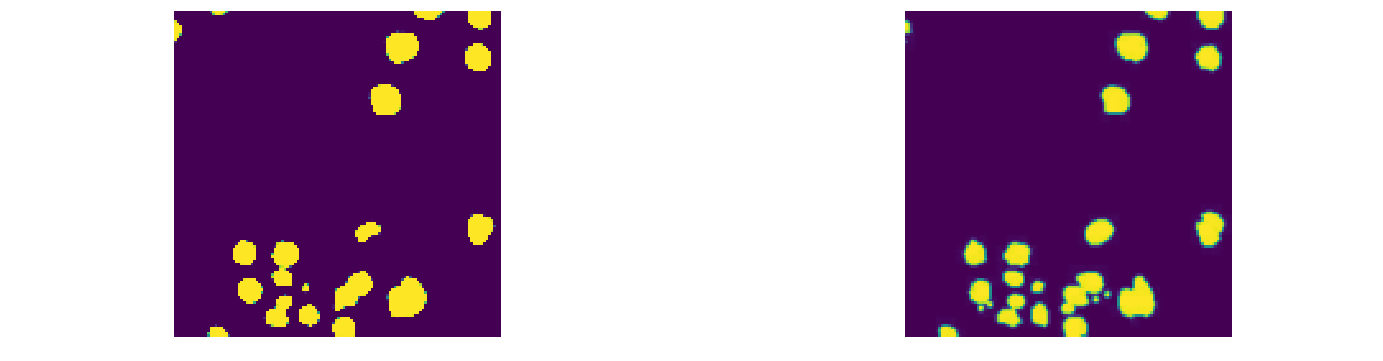

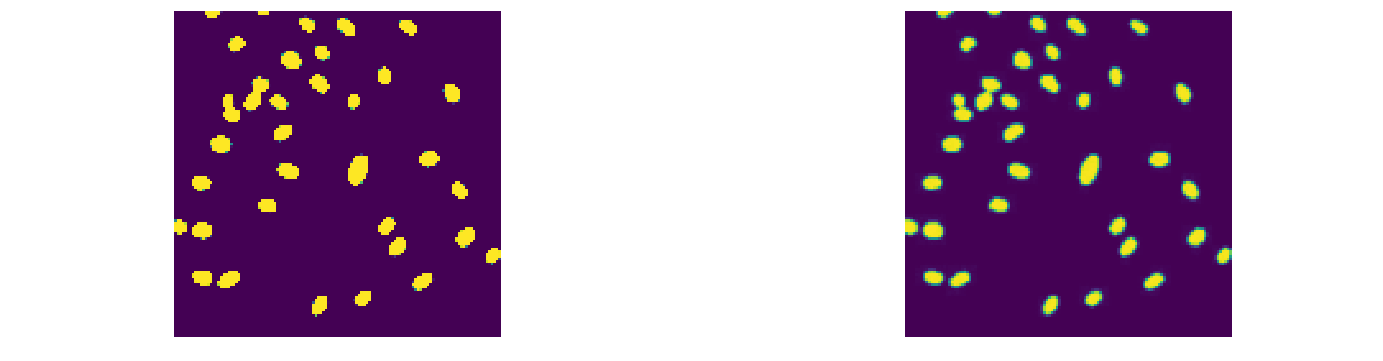

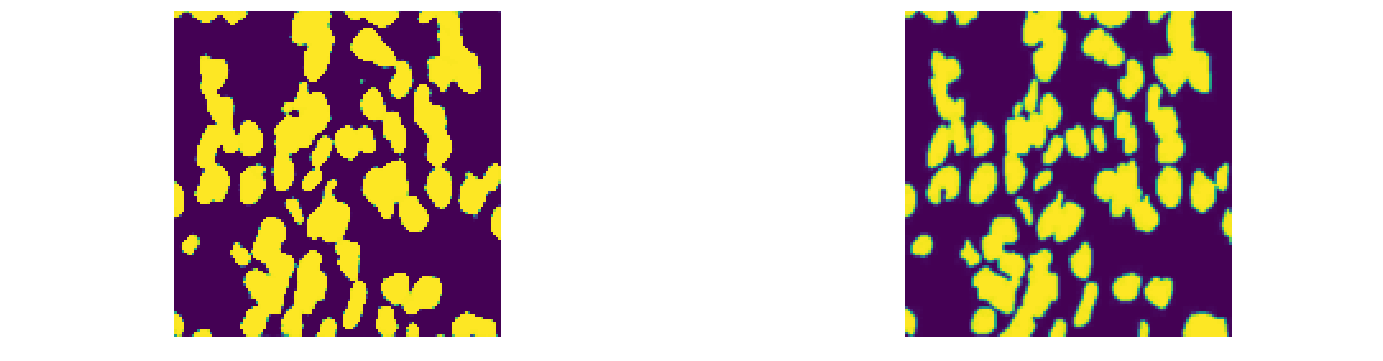

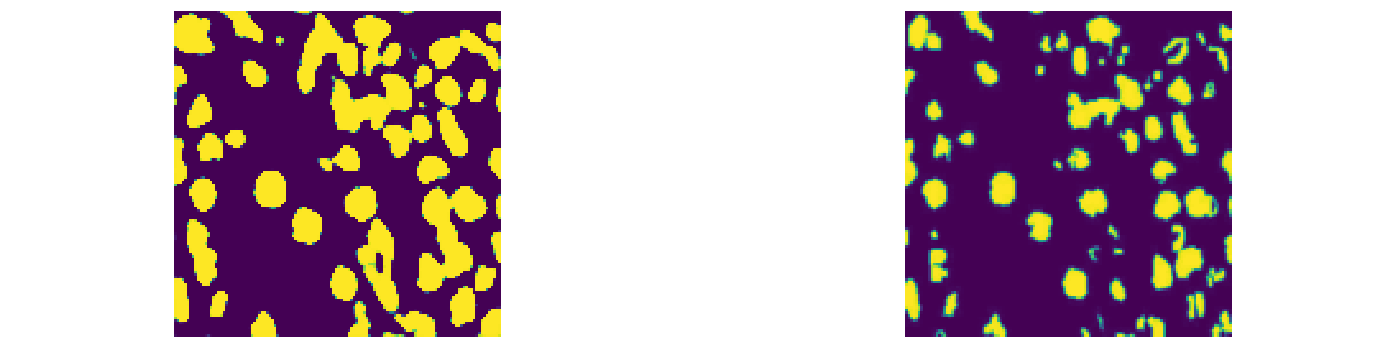

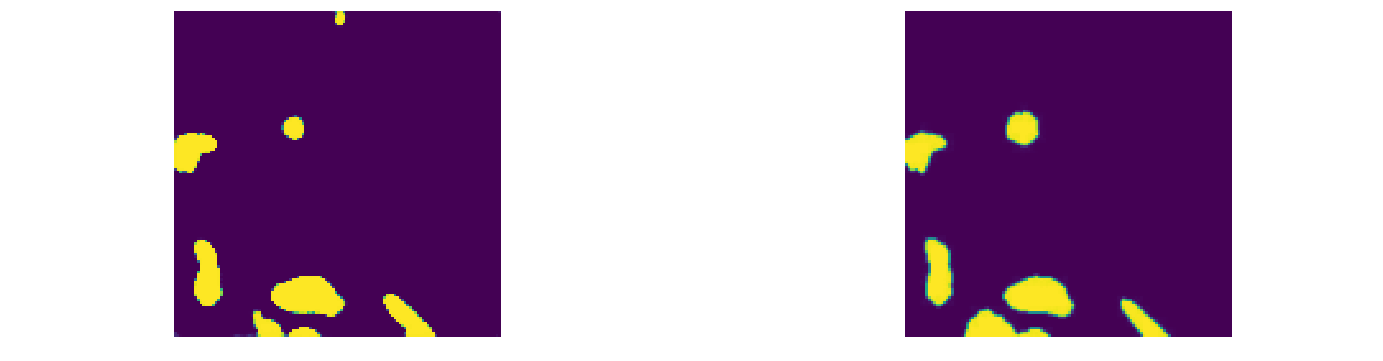

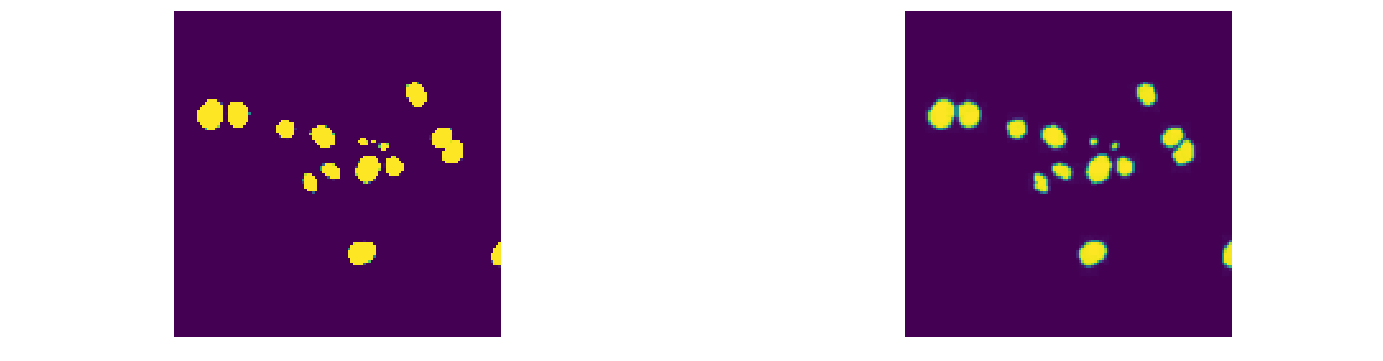

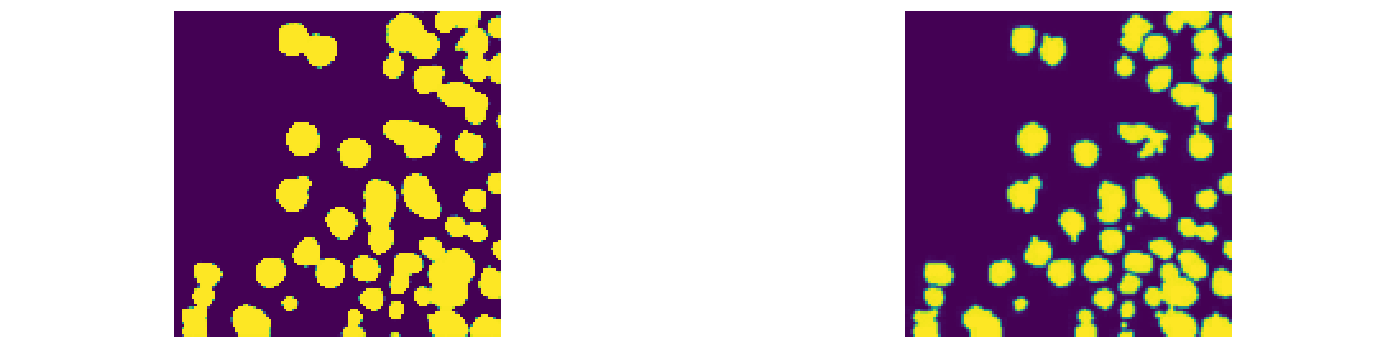

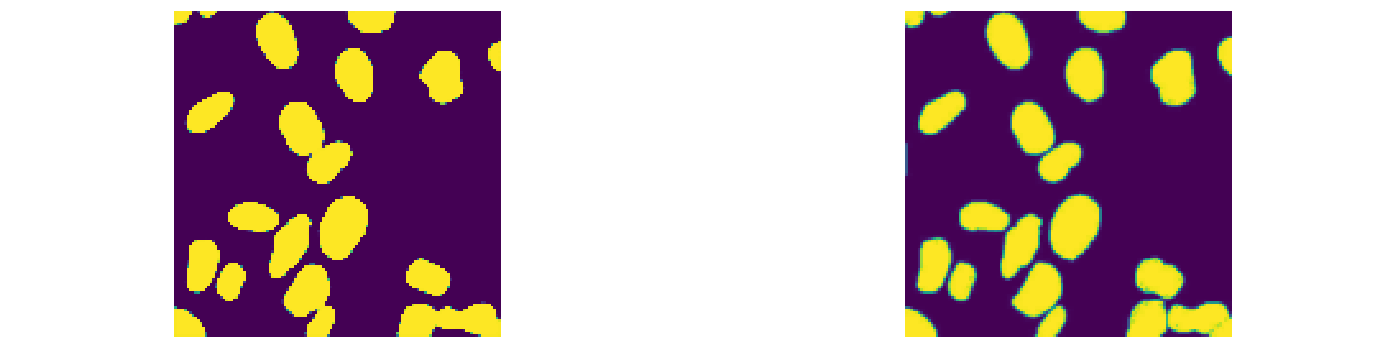

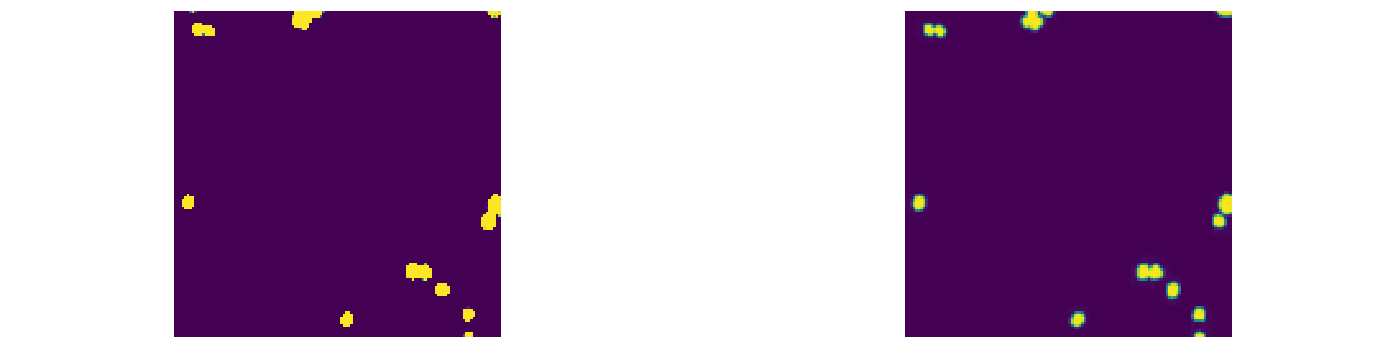

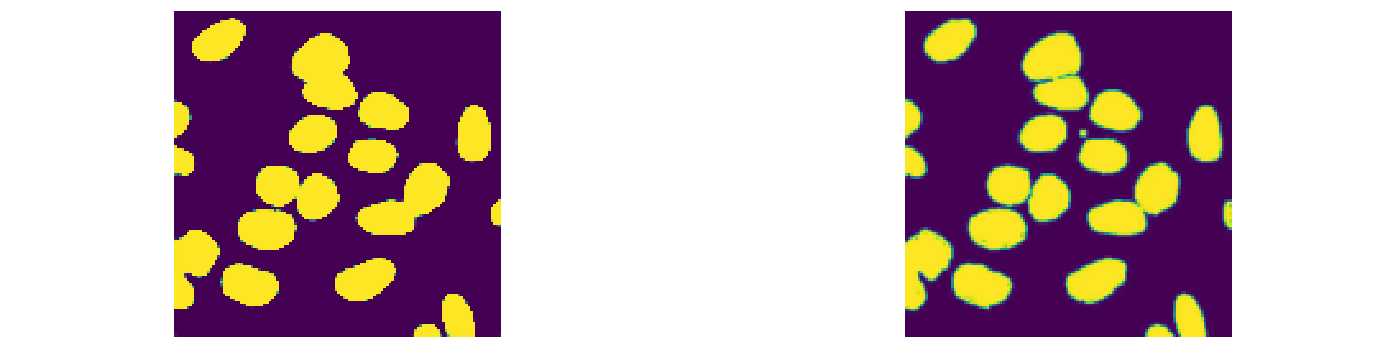

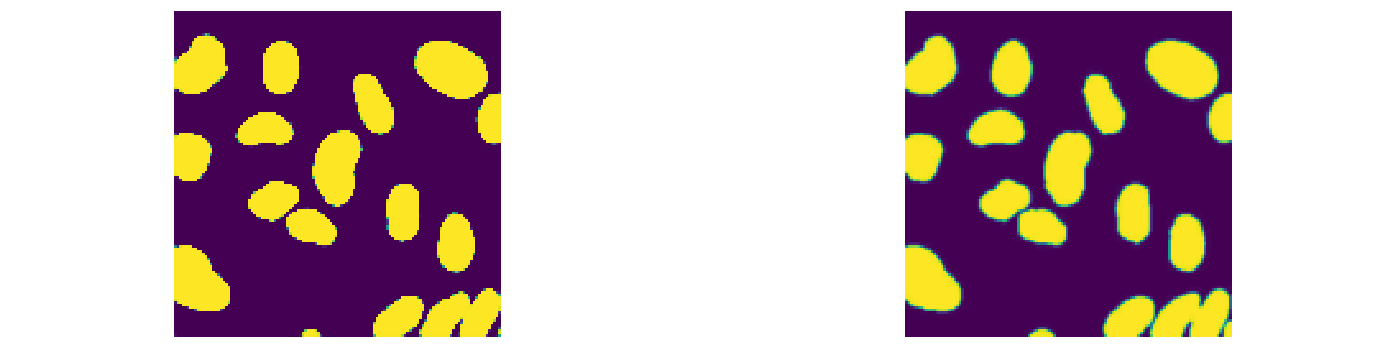

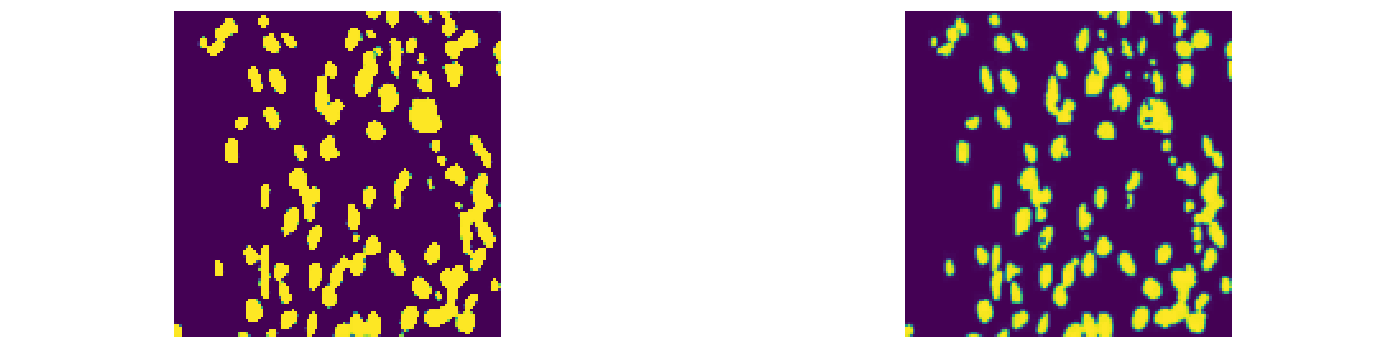

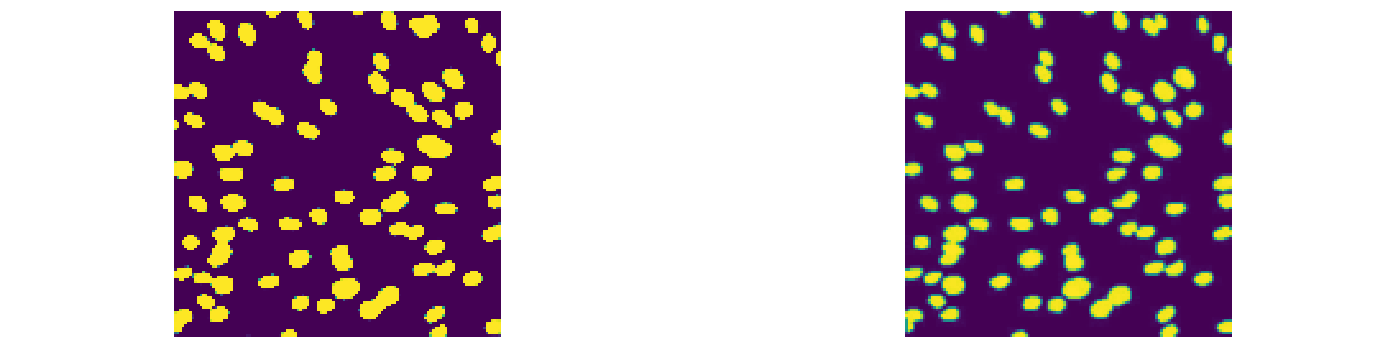

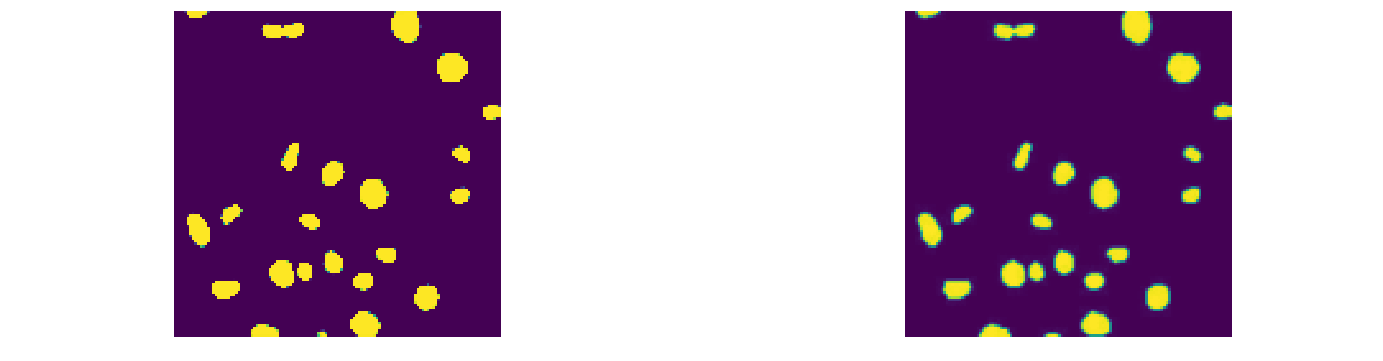

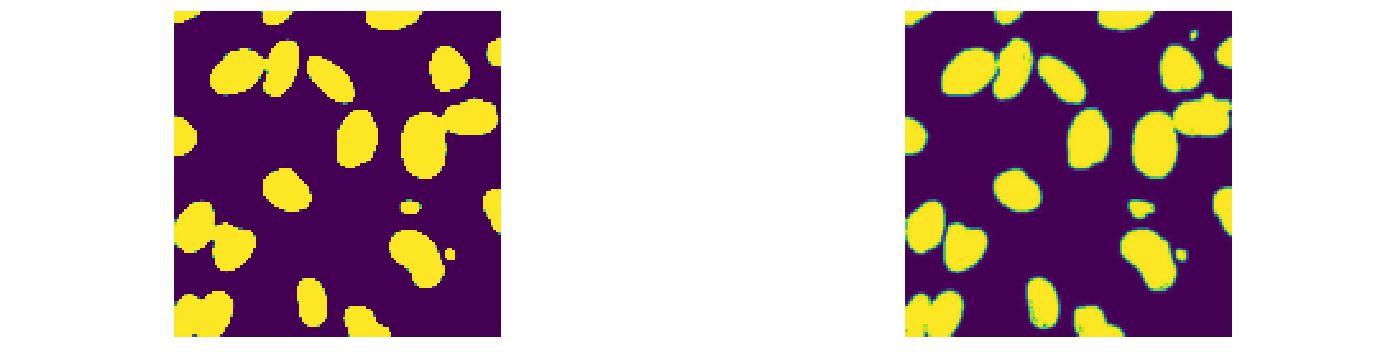

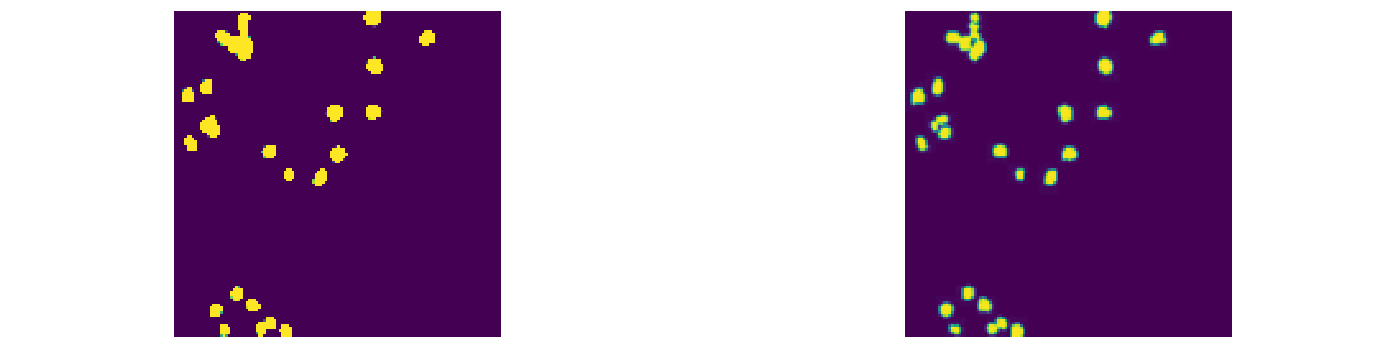

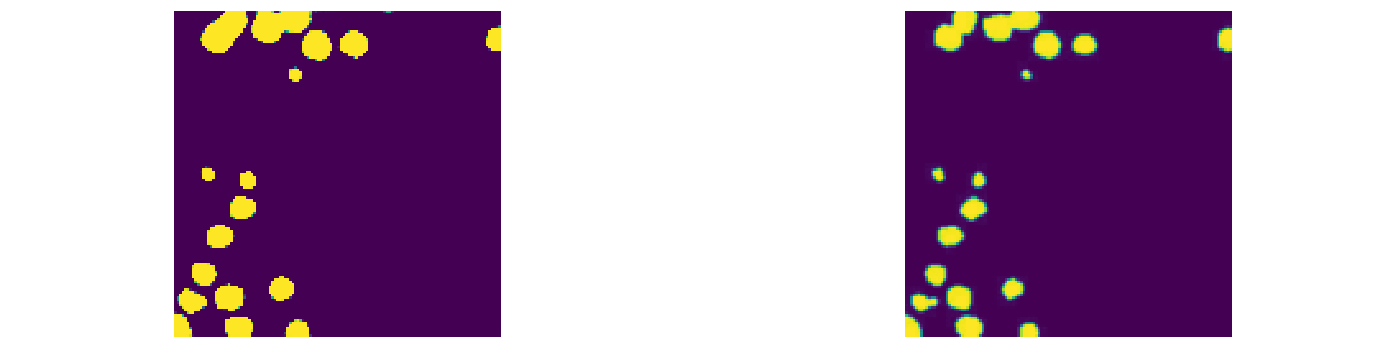

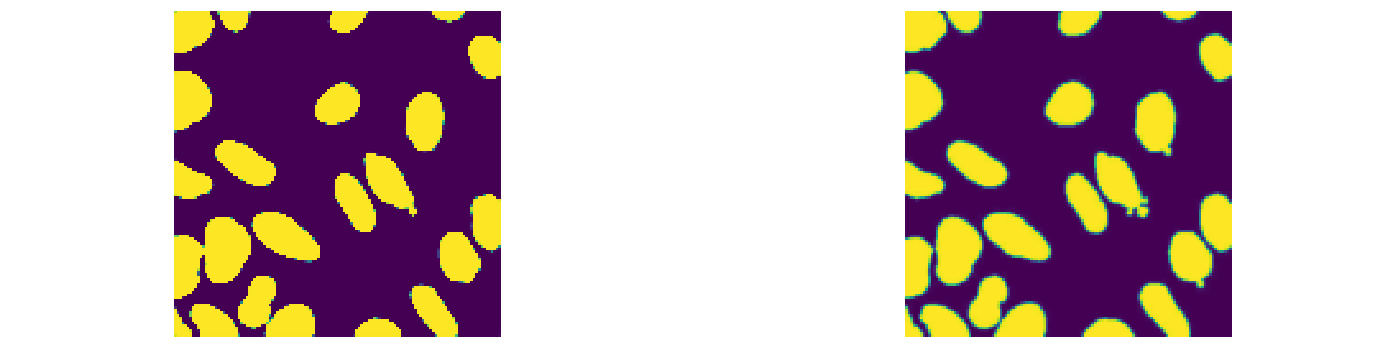

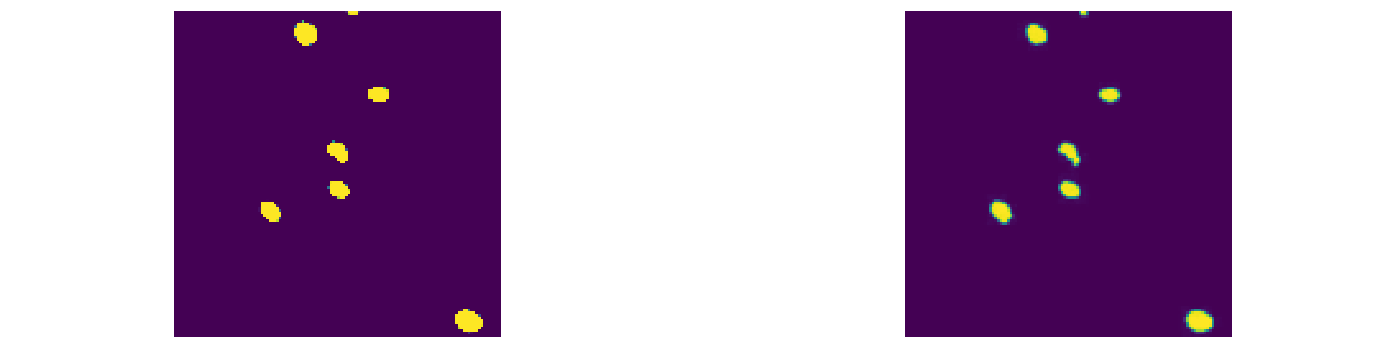

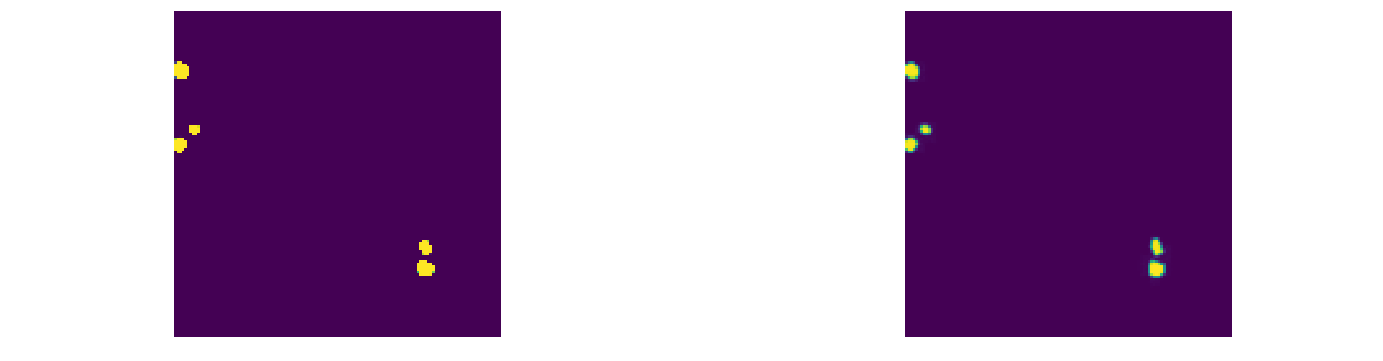

In [31]:
def show_n(img_files, n=6):
    _, ax = plt.subplots(1, n, sharex='col', sharey='row', figsize=(24,6))
    
    for i, img_file in enumerate(img_files):
        ax[i].imshow(img_file)
        ax[i].axis('off')
        
for pred,actual in zip(predicted_masks[:20], actual_masks[:20]):
    show_n([np.asarray(pred), np.asarray(actual)],n=2)

# generating test predictions

In [32]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(),
    transforms.ToTensor()
])


test_transform_size = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = YvanImageFolder(os.path.join(IMG_PATH, 'test_img'), test_transform)
test_loader = data.DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)


test_sizes = YvanImageFolder(os.path.join(IMG_PATH, 'test_img'), test_transform_size)
test_sizes_loader = data.DataLoader(dataset=test_sizes,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)

In [33]:
sizes_in_order = [tuple(batch[0].size()[2:]) for batch, paths in test_sizes_loader]

In [34]:
predicted_names = []
predicted_test = []
ct = 0

for batch, paths in test_loader:
    predicted_names += list(paths[0])
    image_batch = to_variable(batch[0])
    x = unet(image_batch)
    for i in x.data:
        size = sizes_in_order[ct]
        im = transforms.ToPILImage(mode='L')(i.cpu())
        im = im.resize((size[1], size[0]))
        predicted_test.append(im)
        ct += 1

In [35]:
for i in range(len(sizes_in_order)): 
    assert sizes_in_order[i] == np.asarray(predicted_test[i].convert('1')).shape

# make a submission

In [37]:
import pandas as pd

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

test_names = []
test_rles = [] 
for i, (p, path) in enumerate(zip(predicted_test, predicted_names)):
    supposed_size = sizes_in_order[i]
    pred_slide = np.asarray(np.array(p)/255)
    name = os.path.splitext(os.path.basename(path))[0].split('_')[0]
    rles = list(prob_to_rles(pred_slide))
    test_rles.extend(rles)
    test_names.extend([name]*len(rles))

In [38]:
sub = pd.DataFrame()
sub['ImageId'] = test_names
sub['EncodedPixels'] = pd.Series(test_rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.tail(n=15)

,ImageId,EncodedPixels
2046,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,9411 6 9667 6 9921 8 10177 8 10431 10 10687 10...
2047,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,19143 6 19399 6 19653 8 19909 8 20165 8 20421 ...
2048,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,27335 8 27591 8 27845 10 28101 10 28357 10 286...
2049,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,30415 8 30671 8 30925 12 31181 12 31435 14 316...
2050,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15575 8 15831 8 16087 10 16343 10 16597 12 168...
2051,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,26841 6 27097 6 27351 10 27607 10 27863 10 281...
2052,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,41689 8 41945 8 42201 10 42457 10 42713 12 429...
2053,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,20711 4 20967 4 21221 8 21477 8 21731 10 21987...
2054,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,7419 2 7675 2 7927 10 8183 10 8433 16 8689 16 ...
2055,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,239 8 495 8


In [39]:
sub.to_csv(os.path.join(IMG_PATH, 'submissions','feb232018_2.csv'), index=False)

Ok! this got LB 0.254, basically added a batchnorm and moved the maxpool after the convblock for the 'down' blocks.

The score is very sensitve to initilaization and probably batchnorm placement. So we should try MORE batchnorm and dfferent initialization schemes.